<center>

#### AIE425 Intelligent Recommender Systems, Fall Semester 24/25

#### Assignment #1: Neighborhood CF models (user, item-based CF)

#### 221100583, Mohammed Haitham Mohammed

</center>

## Data Collection

##### I used the TMDb API to get top-rated movies with at least 500 votes (up to 100 movies). Then, we generated synthetic ratings for 100 users and saved the data in 'user_movie_ratings.csv'.

In [1]:
import requests
import pandas as pd
import numpy as np
import random

# TMDb API Key
API_KEY = 'd25af2e9ce03aca439b67fdd300c161b'
BASE_URL = 'https://api.themoviedb.org/3'

# Function to fetch top-rated movies with high review counts
def get_top_rated_movies(min_vote_count=500, pages=5):
    movie_list = []
    for page in range(1, pages + 1):
        url = f"{BASE_URL}/movie/top_rated?api_key={API_KEY}&language=en-US&page={page}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()['results']
            filtered_data = [item for item in data if item['vote_count'] >= min_vote_count]
            movie_list.extend(filtered_data)
            if len(movie_list) >= 100:
                break
        else:
            print("Failed to retrieve data:", response.status_code)
            break
    return pd.DataFrame(movie_list[:100])  # Limit to 100 movies

# Get top-rated movies with high review counts
movies_df = get_top_rated_movies()
movies_df = movies_df.sort_values(by='vote_count', ascending=False)
top_10_movies = movies_df.head(10)

# Displaying Top 10 Most-Reviewed Movies
print("\n================== Top 10 Most-Reviewed Movies ==================")
print(top_10_movies[['id', 'title', 'vote_average', 'vote_count']].to_string(index=False))
print("=================================================================\n")

print("Total Movies Collected:", len(movies_df))

# Generate synthetic users and assign ratings
def generate_user_ratings(media_df, num_users=100):
    user_ratings = []
    user_ids = range(1, num_users + 1)
    media_ids = media_df['id'].values
    
    for user_id in user_ids:
        if user_id <= 10:
            # Top 10 users rate the top 10 most-reviewed movies
            rated_media = top_10_movies['id'].values
        else:
            # Other users rate a random selection of movies (10-20 movies)
            rated_media = np.random.choice(media_ids, size=random.randint(10, 20), replace=False)
        
        for media_id in rated_media:
            base_rating = media_df[media_df['id'] == media_id]['vote_average'].values[0]
            user_rating = round(base_rating + random.uniform(-1, 1), 1)  # Adding noise for personalization
            user_ratings.append({'user_id': user_id, 'media_id': media_id, 'rating': user_rating})
    
    return pd.DataFrame(user_ratings)

# Generate user ratings for collected movies
user_ratings_df = generate_user_ratings(movies_df, num_users=100)

# Merge user ratings with movie details for a complete view
detailed_user_ratings_df = user_ratings_df.merge(movies_df[['id', 'title']], left_on='media_id', right_on='id').drop('id', axis=1)

# Save to CSV
csv_filename = 'user_movie_ratings.csv'
detailed_user_ratings_df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully with 100 movies and 100 users.\n")

# Display Sample Data
print("\n================== Sample Data from User Ratings ==================")
print(detailed_user_ratings_df.head(10).to_string(index=False))
print("===================================================================\n")

# Display Top 10 Most-Reviewed Movies and Their Ratings by Top 10 Users
top_user_ratings = detailed_user_ratings_df[(detailed_user_ratings_df['user_id'] <= 10) & 
                                            (detailed_user_ratings_df['media_id'].isin(top_10_movies['id']))]

print("\n=========== Top 10 Most-Reviewed Movies Rated by Top 10 Users ===========")
print(top_user_ratings[['user_id', 'media_id', 'rating', 'title']].to_string(index=False))
print("==========================================================================\n")


================== Top 10 Most-Reviewed Movies ==================
    id                                             title  vote_average  vote_count
 27205                                         Inception         8.400       36462
157336                                      Interstellar         8.400       35464
   155                                   The Dark Knight         8.500       32785
299536                            Avengers: Infinity War         8.243       29630
   550                                        Fight Club         8.438       29284
   680                                      Pulp Fiction         8.488       27820
    13                                      Forrest Gump         8.500       27345
   278                          The Shawshank Redemption         8.700       27039
299534                                 Avengers: Endgame         8.200       25521
   120 The Lord of the Rings: The Fellowship of the Ring         8.416       25062

Total Movies Collec

## Data Preprocessing

##### Cleaned and formatted the data by:

1. Removing duplicate entries.

2. Converting ratings to integers.

3. Reordering columns.

4. Saving cleaned data as 'cleaned_user_movie_ratings.csv'.



In [2]:
import pandas as pd

# Load the initial CSV file generated from Data Collection
df = pd.read_csv('user_movie_ratings.csv')

# Step 1: Clean the Data
df.drop_duplicates(subset=['user_id', 'media_id'], keep='first', inplace=True)

# Step 2: Convert Ratings to Integer Format
df['rating'] = df['rating'].round(0).astype(int)

# Step 3: Ensure Consistent Formatting
# Confirm columns: user_id, media_id, rating, title
df = df[['user_id', 'media_id', 'rating', 'title']]

# Step 4: Save the Cleaned Data
cleaned_csv_filename = 'cleaned_user_movie_ratings.csv'
df.to_csv(cleaned_csv_filename, index=False)

# Display a sample of the cleaned data
print(f"Cleaned data saved to '{cleaned_csv_filename}'")
print("\n================== Sample of Cleaned Data ==================")
print(df.head(10).to_string(index=False))
print("============================================================\n")

Cleaned data saved to 'cleaned_user_movie_ratings.csv'

================== Sample of Cleaned Data ==================
 user_id  media_id  rating                                             title
       1     27205       8                                         Inception
       1    157336       8                                      Interstellar
       1       155       8                                   The Dark Knight
       1    299536       8                            Avengers: Infinity War
       1       550       8                                        Fight Club
       1       680       8                                      Pulp Fiction
       1        13       9                                      Forrest Gump
       1       278       9                          The Shawshank Redemption
       1    299534       8                                 Avengers: Endgame
       1       120       8 The Lord of the Rings: The Fellowship of the Ring



## User-Item Matrix Creation

##### In this section, I created a 10x10 user-item matrix for further analysis:

1. Top 10 Users and Movies: Selected the top 10 users and top 10 movies based on their rating counts.

2. Filtering Data: Filtered the dataset to include only the ratings from the top 10 users for the top 10 movies.

3. Creating User-Item Matrix: Created a 10x10 user-item matrix using the filtered data, with missing ratings filled in as 0.

4. Saving the Matrix: Saved the user-item matrix as 'user_item_matrix_10x10.csv'.

In [3]:
import pandas as pd

# Load the cleaned ratings data
df = pd.read_csv('cleaned_user_movie_ratings.csv')

# Step 1: Identify the Top 10 Users by Total Ratings Count
top_10_users = df['user_id'].value_counts().nlargest(10).index.tolist()

# Step 2: Identify the Top 10 Movies by Total Ratings Count
top_10_movies = df['media_id'].value_counts().nlargest(10).index.tolist()

# Step 3: Filter the Data to Include Only Top 10 Users and Top 10 Movies
filtered_df = df[df['user_id'].isin(top_10_users) & df['media_id'].isin(top_10_movies)]

# Step 4: Create the 10x10 User-Item Matrix
user_item_matrix_10x10 = filtered_df.pivot(index='user_id', columns='media_id', values='rating')

# Fill missing values with 0 to indicate no rating
user_item_matrix_10x10.fillna(0, inplace=True)

# Step 5: Save the User-Item Matrix
matrix_csv_filename = 'user_item_matrix_10x10.csv'
user_item_matrix_10x10.to_csv(matrix_csv_filename)

# Display the 10x10 User-Item Matrix
print(f"10x10 User-Item matrix saved to '{matrix_csv_filename}'")
print("\n================== 10x10 User-Item Matrix ==================")
print(user_item_matrix_10x10.to_string())
print("============================================================\n")

10x10 User-Item matrix saved to 'user_item_matrix_10x10.csv'

================== 10x10 User-Item Matrix ==================
media_id  155     278     550     680     12477   77338   92321   157336  299534  299536
user_id                                                                                 
11           0.0     0.0     8.0     0.0     0.0     0.0     0.0     0.0     0.0     9.0
14           0.0     0.0     0.0     0.0     0.0     8.0     9.0     9.0     0.0     0.0
27           0.0     0.0     0.0     0.0     0.0     0.0     0.0     9.0     0.0     8.0
32           0.0     8.0     9.0     8.0     0.0     0.0     0.0     0.0     8.0     9.0
36           0.0     0.0     8.0     0.0     0.0     0.0     9.0     0.0     0.0     0.0
41           0.0     0.0     0.0     0.0     0.0     0.0     9.0     8.0     8.0     0.0
55           0.0     0.0     0.0     0.0     0.0     9.0     0.0     0.0     0.0     0.0
60           8.0     8.0     8.0     0.0     0.0     0.0     0.0     0.0    

## Average Rating Calculation

##### In this section, I calculated the average rating for each item:

1. Loading User-Item Matrix: Loaded the 10x10 user-item matrix from 'user_item_matrix_10x10.csv'.

2. Calculating Average Ratings: Calculated the average rating for each item, ignoring zeros (indicating no rating).

3. Saving Average Ratings: Saved the average ratings to 'average_item_ratings.csv'.

In [4]:
import pandas as pd

# Step 1: Load the 10x10 User-Item Matrix
user_item_matrix = pd.read_csv('user_item_matrix_10x10.csv', index_col='user_id')

# Step 2: Calculate the Average Rating per Item (ignoring 0 values)
average_ratings = user_item_matrix.replace(0, pd.NA).mean(skipna=True)

# Convert the average ratings to a DataFrame for better formatting
average_ratings_df = pd.DataFrame(average_ratings, columns=['average_rating'])

# Step 3: Save the Average Ratings
average_ratings_csv_filename = 'average_item_ratings.csv'
average_ratings_df.to_csv(average_ratings_csv_filename)

# Display the Average Ratings
print(f"Average ratings saved to '{average_ratings_csv_filename}'")
print("\n================== Average Rating per Item ==================")
print(average_ratings_df.to_string())
print("============================================================\n")

Average ratings saved to 'average_item_ratings.csv'

================== Average Rating per Item ==================
       average_rating
155               8.5
278               8.0
550          8.333333
680               8.0
12477             8.0
77338             8.5
92321             9.0
157336       8.666667
299534            8.0
299536           8.75



## Similarity Computation (Cosine Similarity and Pearson Correlation)

##### In this section, I computed similarity matrices for both users and items:

1. Cosine Similarity: Computed user-based and item-based cosine similarity matrices to identify relationships between users and items.

2. Pearson Correlation: Calculated user-based and item-based Pearson correlation matrices to explore how users and items are correlated.

3. Plotting: Visualized the similarity matrices using heatmaps to highlight similarity patterns.

4. Saving Results: Saved all similarity matrices as CSV files for further analysis.


================== User-Based Cosine Similarity Matrix ==================
user_id        11        14        27        32        36        41        55  \
user_id                                                                         
11       1.000000  0.000000  0.496552  0.675314  0.441379  0.000000  0.000000   
14       0.000000  1.000000  0.447452  0.000000  0.447452  0.703986  0.532152   
27       0.496552  0.447452  1.000000  0.317795  0.000000  0.413595  0.000000   
32       0.675314  0.000000  0.317795  1.000000  0.317795  0.235291  0.000000   
36       0.441379  0.447452  0.000000  0.317795  1.000000  0.465294  0.000000   
41       0.000000  0.703986  0.413595  0.235291  0.465294  1.000000  0.000000   
55       0.000000  0.532152  0.000000  0.000000  0.000000  0.000000  1.000000   
60       0.383571  0.000000  0.000000  0.521659  0.383571  0.000000  0.000000   
64       0.675314  0.000000  0.317795  0.819209  0.317795  0.235291  0.000000   
88       0.367640  0.000000  0.000

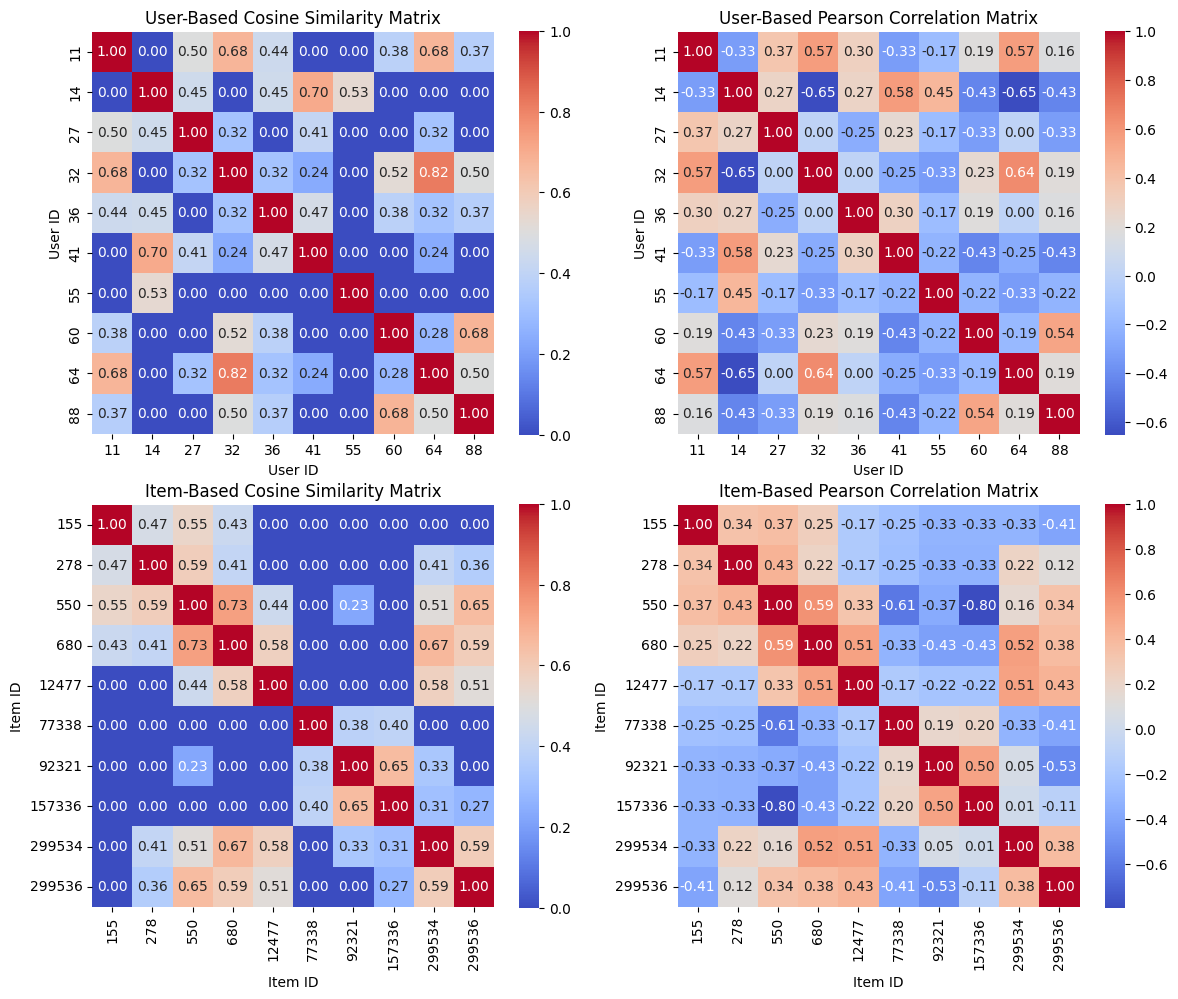

User-based cosine similarity matrix saved to 'user_cosine_similarity_matrix.csv'
User-based Pearson correlation matrix saved to 'user_pearson_correlation_matrix.csv'
Item-based cosine similarity matrix saved to 'item_cosine_similarity_matrix.csv'
Item-based Pearson correlation matrix saved to 'item_pearson_correlation_matrix.csv'


In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Load the User-Item Matrix
user_item_matrix = pd.read_csv('user_item_matrix_10x10.csv', index_col=0)

# Step 1: Compute Cosine Similarity for User-Based CF
def compute_cosine_similarity(matrix):
    return pd.DataFrame(cosine_similarity(matrix), index=matrix.index, columns=matrix.index)

# Step 2: Compute Pearson Correlation for User-Based CF
def compute_pearson_correlation(matrix):
    user_ids = matrix.index
    correlation_matrix = pd.DataFrame(index=user_ids, columns=user_ids)

    for user1 in user_ids:
        for user2 in user_ids:
            if user1 != user2:
                corr, _ = pearsonr(matrix.loc[user1], matrix.loc[user2])
                correlation_matrix.loc[user1, user2] = corr
            else:
                correlation_matrix.loc[user1, user2] = 1.0  # Self-similarity

    correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)
    return correlation_matrix

# Step 3: Compute Item-Based Similarity
def compute_item_based_similarity(matrix):
    return pd.DataFrame(cosine_similarity(matrix.T), index=matrix.columns, columns=matrix.columns)

# Step 4: Compute Item-Based Pearson Correlation
def compute_item_based_pearson_correlation(matrix):
    item_ids = matrix.columns
    correlation_matrix = pd.DataFrame(index=item_ids, columns=item_ids)

    for item1 in item_ids:
        for item2 in item_ids:
            if item1 != item2:
                corr, _ = pearsonr(matrix[item1], matrix[item2])
                correlation_matrix.loc[item1, item2] = corr
            else:
                correlation_matrix.loc[item1, item2] = 1.0  # Self-similarity

    correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)
    return correlation_matrix

# Step 5: Compute Similarity Matrices
cosine_similarity_matrix_user = compute_cosine_similarity(user_item_matrix)
pearson_correlation_matrix_user = compute_pearson_correlation(user_item_matrix)

cosine_similarity_matrix_item = compute_item_based_similarity(user_item_matrix)
pearson_correlation_matrix_item = compute_item_based_pearson_correlation(user_item_matrix)

# Step 6: Display Similarity Results
print("\n================== User-Based Cosine Similarity Matrix ==================")
print(cosine_similarity_matrix_user)
print("==============================================================\n")

print("\n================== User-Based Pearson Correlation Matrix ==================")
print(pearson_correlation_matrix_user)
print("==============================================================\n")

print("\n================== Item-Based Cosine Similarity Matrix ==================")
print(cosine_similarity_matrix_item)
print("==============================================================\n")

print("\n================== Item-Based Pearson Correlation Matrix ==================")
print(pearson_correlation_matrix_item)
print("==============================================================\n")

# Step 7: Plot the Similarity Matrices
plt.figure(figsize=(12, 10))

# Plot User-Based Cosine Similarity
plt.subplot(2, 2, 1)
sns.heatmap(cosine_similarity_matrix_user, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('User-Based Cosine Similarity Matrix')
plt.xlabel('User ID')
plt.ylabel('User ID')

# Plot User-Based Pearson Correlation
plt.subplot(2, 2, 2)
sns.heatmap(pearson_correlation_matrix_user, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('User-Based Pearson Correlation Matrix')
plt.xlabel('User ID')
plt.ylabel('User ID')

# Plot Item-Based Cosine Similarity
plt.subplot(2, 2, 3)
sns.heatmap(cosine_similarity_matrix_item, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Item-Based Cosine Similarity Matrix')
plt.xlabel('Item ID')
plt.ylabel('Item ID')

# Plot Item-Based Pearson Correlation
plt.subplot(2, 2, 4)
sns.heatmap(pearson_correlation_matrix_item, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Item-Based Pearson Correlation Matrix')
plt.xlabel('Item ID')
plt.ylabel('Item ID')

plt.tight_layout()
plt.show()

# Step 8: Save Similarity Matrices to CSV (if needed)
cosine_user_csv_filename = 'user_cosine_similarity_matrix.csv'
pearson_user_csv_filename = 'user_pearson_correlation_matrix.csv'
cosine_item_csv_filename = 'item_cosine_similarity_matrix.csv'
pearson_item_csv_filename = 'item_pearson_correlation_matrix.csv'

cosine_similarity_matrix_user.to_csv(cosine_user_csv_filename)
pearson_correlation_matrix_user.to_csv(pearson_user_csv_filename)
cosine_similarity_matrix_item.to_csv(cosine_item_csv_filename)
pearson_correlation_matrix_item.to_csv(pearson_item_csv_filename)

print(f"User-based cosine similarity matrix saved to '{cosine_user_csv_filename}'")
print(f"User-based Pearson correlation matrix saved to '{pearson_user_csv_filename}'")
print(f"Item-based cosine similarity matrix saved to '{cosine_item_csv_filename}'")
print(f"Item-based Pearson correlation matrix saved to '{pearson_item_csv_filename}'")


## Comparison of Results (Cosine Similarity vs. Pearson Correlation)

##### In this section, I compared the performance of Cosine Similarity and Pearson Correlation in predicting user ratings:

1. Prediction Calculation: Calculated predicted ratings for both cosine similarity and Pearson correlation using a user-based collaborative filtering approach.

2. Error Metrics: Evaluated prediction accuracy using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for both methods.

3. Results: Displayed and visualized the comparison of MAE and RMSE for Cosine Similarity and Pearson Correlation to understand their effectiveness.

4. The results help determine which similarity metric performs better for rating prediction, providing insights for further model optimization.




================== Comparison of Results ==================
Cosine Similarity - MAE: 6.69, RMSE: 7.49
Pearson Correlation - MAE: 7.00, RMSE: 7.41



C:\Users\medoh\AppData\Local\Temp\ipykernel_25956\2701944091.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions.fillna(0, inplace=True)
c:\Users\medoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\medoh\AppData\Local\Temp\ipykernel_25956\2701944091.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre

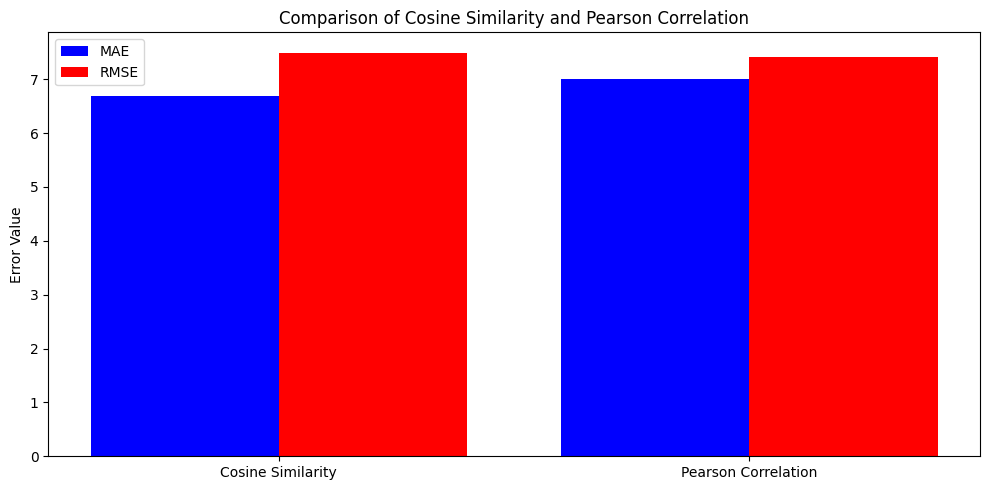

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the User-Item Matrix
user_item_matrix = pd.read_csv('user_item_matrix_10x10.csv', index_col=0)

# Step 1: User-Based Prediction Calculation Function (Cosine Similarity)
def predict_ratings_user_based(user_id, item_id, user_item_matrix, similarity_matrix):
    user_index = user_item_matrix.index.get_loc(user_id)
    sim_scores = similarity_matrix[user_id]
    item_ratings = user_item_matrix[item_id]
    
    weighted_sum = np.dot(sim_scores, item_ratings)
    sim_sum = np.sum(np.abs(sim_scores[item_ratings > 0]))

    if sim_sum == 0:
        return 0  # No prediction can be made
    else:
        return weighted_sum / sim_sum

# Step 2: Calculate Predictions for Cosine Similarity
predictions = pd.DataFrame(index=user_item_matrix.index, columns=user_item_matrix.columns)

for user_id in user_item_matrix.index:
    for item_id in user_item_matrix.columns:
        if user_item_matrix.loc[user_id, item_id] == 0:  # Only predict if the rating is missing
            predictions.loc[user_id, item_id] = predict_ratings_user_based(user_id, item_id, user_item_matrix, cosine_similarity_matrix_user)


# Step 3: Handle NaN Values
# Fill any NaN predictions with 0
predictions.fillna(0, inplace=True)

# Step 4: Calculate MAE and RMSE for Cosine Similarity
mae_cosine = mean_absolute_error(user_item_matrix.values.flatten(), predictions.values.flatten())
rmse_cosine = mean_squared_error(user_item_matrix.values.flatten(), predictions.values.flatten(), squared=False)

# Step 5: Calculate Predictions for Pearson Correlation (Similar process)
predictions_pearson = pd.DataFrame(index=user_item_matrix.index, columns=user_item_matrix.columns)

for user_id in user_item_matrix.index:
    for item_id in user_item_matrix.columns:
        if user_item_matrix.loc[user_id, item_id] == 0:  # Only predict if the rating is missing
            predictions_pearson.loc[user_id, item_id] = predict_ratings_user_based(user_id, item_id, user_item_matrix, pearson_correlation_matrix_user)

# Handle NaN Values for Pearson Predictions
predictions_pearson.fillna(0, inplace=True)

# Step 6: Calculate MAE and RMSE for Pearson Correlation
mae_pearson = mean_absolute_error(user_item_matrix.values.flatten(), predictions_pearson.values.flatten())
rmse_pearson = mean_squared_error(user_item_matrix.values.flatten(), predictions_pearson.values.flatten(), squared=False)

# Step 7: Display Comparison Results
print("\n================== Comparison of Results ==================")
print(f"Cosine Similarity - MAE: {mae_cosine:.2f}, RMSE: {rmse_cosine:.2f}")
print(f"Pearson Correlation - MAE: {mae_pearson:.2f}, RMSE: {rmse_pearson:.2f}")
print("==========================================================\n")

# Optional: Visual Representation
import matplotlib.pyplot as plt

labels = ['Cosine Similarity', 'Pearson Correlation']
mae_values = [mae_cosine, mae_pearson]
rmse_values = [rmse_cosine, rmse_pearson]

x = range(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x, mae_values, width=0.4, label='MAE', color='b', align='center')
plt.bar([p + 0.4 for p in x], rmse_values, width=0.4, label='RMSE', color='r', align='center')

plt.xticks([p + 0.2 for p in x], labels)
plt.ylabel('Error Value')
plt.title('Comparison of Cosine Similarity and Pearson Correlation')
plt.legend()
plt.tight_layout()
plt.show()

## Prediction Calculation

##### In this section, I calculated user-based predictions for missing ratings:

1. User-Based Prediction Function: Created a function to predict missing ratings using a weighted sum of user similarities and item ratings.

2. Calculate Predictions: Computed predictions for all users and items where ratings were missing, using the user-based cosine similarity matrix.

3. Display and Save: Displayed a sample of the predicted ratings and saved the complete predictions to 'predicted_ratings.csv'.

In [7]:
import numpy as np

# Step 1: User-Based Prediction Calculation Function
def predict_ratings_user_based(user_id, item_id, user_item_matrix, similarity_matrix):
    # Get the index of the user
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # Get the similarity scores for the user
    sim_scores = similarity_matrix[user_id]
    
    # Get the ratings for the specific item by all users
    item_ratings = user_item_matrix[item_id]
    
    # Calculate the weighted sum of ratings
    weighted_sum = np.dot(sim_scores, item_ratings)
    # Calculate the sum of similarity scores for the item
    sim_sum = np.sum(np.abs(sim_scores[item_ratings > 0]))
    
    # Avoid division by zero
    if sim_sum == 0:
        return 0  # No prediction can be made
    else:
        return weighted_sum / sim_sum

# Step 2: Calculate Predictions for All Users and Items
predictions = pd.DataFrame(index=user_item_matrix.index, columns=user_item_matrix.columns)

for user_id in user_item_matrix.index:
    for item_id in user_item_matrix.columns:
        if user_item_matrix.loc[user_id, item_id] == 0:  # Only predict if the rating is missing
            predictions.loc[user_id, item_id] = predict_ratings_user_based(user_id, item_id, user_item_matrix, cosine_similarity_matrix_user)

# Step 3: Display Sample of Predicted Ratings
print("\n================== Predicted Ratings ==================")
print(predictions.head(10).to_string())
print("========================================================\n")

# Step 4: Save Predicted Ratings to CSV
predicted_ratings_csv_filename = 'predicted_ratings.csv'
predictions.to_csv(predicted_ratings_csv_filename)

print(f"Predicted ratings saved to '{predicted_ratings_csv_filename}'")



================== Predicted Ratings ==================
              155  278       550  680 12477 77338 92321    157336 299534    299536
user_id                                                                           
11       8.489397  8.0       NaN  8.0   8.0     0   9.0       9.0    8.0       NaN
14              0    0       8.0    0     0   NaN   NaN       NaN    8.0       8.0
27              0  8.0  8.561405  8.0   8.0   8.0   9.0       NaN    8.0       NaN
32       8.489397  NaN       NaN  NaN   8.0     0   9.0  8.574585    NaN       NaN
36       8.489397  8.0       NaN  8.0   8.0   8.0   NaN  8.490226    8.0       9.0
41              0  8.0  8.502825  8.0   8.0   8.0   NaN       NaN    NaN  8.532226
55              0    0         0    0     0   NaN   9.0       9.0      0         0
60            NaN  NaN       NaN  8.0   8.0     0   9.0         0    8.0       9.0
64       8.644184  8.0       NaN  NaN   NaN     0   9.0  8.574585    NaN       NaN
88            NaN  8.0       N

## Top-N Recommendations

##### In this section, I generated and analyzed Top-N recommendations for users and items:

1. Top-N Recommendation Generation: Created a function to generate Top-N recommendations for users based on the predicted ratings using Cosine Similarity and Pearson Correlation.

2. User-Based and Item-Based Recommendations: Obtained Top-N recommendations for both user-based and item-based collaborative filtering methods, applying noise and threshold values for diversity.

3. Visualization: Plotted the Top-N recommendations to visualize the ranking of recommended movies for users and the most recommended users for items.

4. Output: Displayed the Top-N recommendations for both cosine similarity and Pearson correlation to compare the results for different approaches.

Top-N Recommendations for Users (User-Based CF):
Cosine Similarity:
User 11: ['92321', '157336', '155', '12477', '680']
User 14: ['550', '299536', '299534', '12477', '680']
User 27: ['92321', '550', '278', '299534', '77338']
User 32: ['92321', '157336', '155', '12477', '299534']
User 36: ['299536', '157336', '155', '77338', '278']
User 41: ['550', '299536', '77338', '278', '680']
User 55: ['92321', '157336', '680', '299536', '299534']
User 60: ['92321', '299536', '12477', '299534', '680']
User 64: ['92321', '157336', '155', '278', '299534']
User 88: ['299536', '92321', '278', '299534', '12477']

Pearson Correlation:
User 11: ['155', '12477', '278', '680', '299534']
User 14: ['157336', '77338', '92321', '299534', '299536']
User 27: ['12477', '299534', '92321', '77338', '299536']
User 32: ['155', '12477', '278', '550', '299534']
User 36: ['155', '12477', '299534', '680', '278']
User 41: ['77338', '92321', '299534', '157336', '299536']
User 55: ['157336', '92321', '77338', '12477', '278']

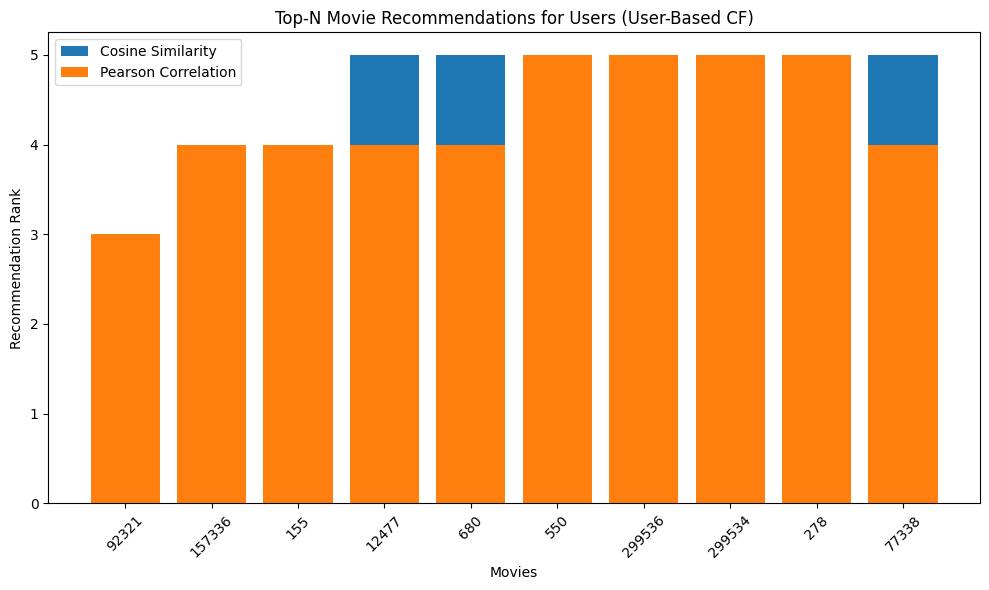


Top-N Recommendations for Items (Item-Based CF):
Cosine Similarity:
Item 11: ['92321', '157336', '155']
Item 14: ['550', '299534', '299536']
Item 27: ['92321', '550', '278']
Item 32: ['92321', '157336', '155']
Item 36: ['299536', '157336', '155']
Item 41: ['299536', '550', '278']
Item 55: ['92321', '157336']
Item 60: ['92321', '299536', '680']
Item 64: ['92321', '155', '157336']
Item 88: ['92321', '299536', '278']

Pearson Correlation:
Item 11: ['155', '278', '680']
Item 14: []
Item 27: ['12477', '299534']
Item 32: ['155', '12477']
Item 36: ['155', '278', '680']
Item 41: ['77338']
Item 55: []
Item 60: ['680']
Item 64: ['278']
Item 88: ['278', '12477']


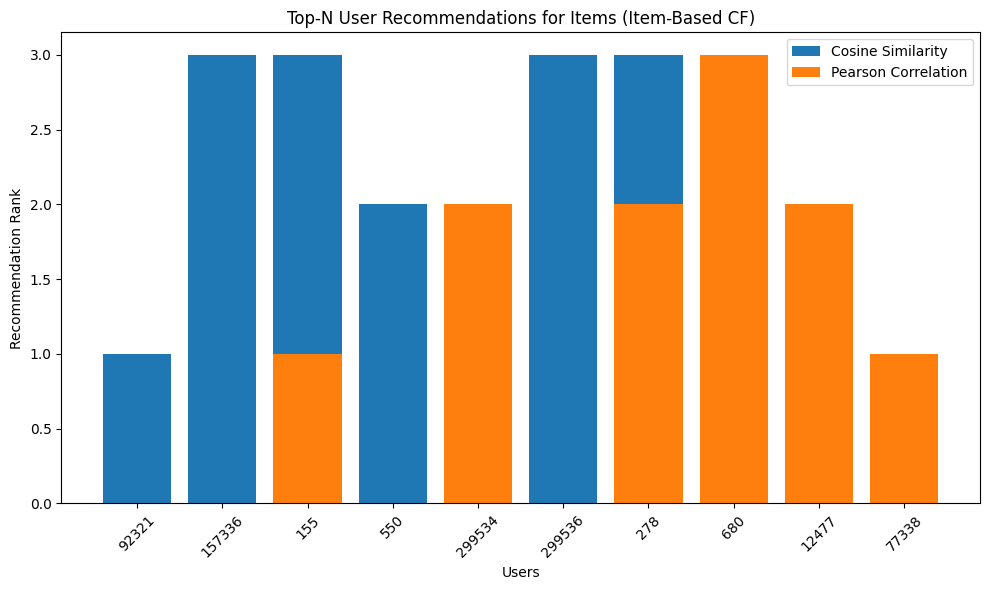

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure predictions DataFrames are numeric
predictions = predictions.apply(pd.to_numeric, errors='coerce').fillna(0)
predictions_pearson = predictions_pearson.apply(pd.to_numeric, errors='coerce').fillna(0)

# Function to get Top-N recommendations for a user with optional threshold and noise
def get_top_n_recommendations(predictions, n=5, threshold=None, noise_level=0):
    top_n = {}
    for user_id in predictions.index:
        user_ratings = predictions.loc[user_id]

        # Apply threshold if specified
        if threshold:
            user_ratings = user_ratings[user_ratings >= threshold]

        # Add random noise if specified
        if noise_level > 0:
            user_ratings = user_ratings + np.random.normal(0, noise_level, user_ratings.shape)

        # Get top N recommendations
        top_n[user_id] = user_ratings.nlargest(n).index.tolist()
    return top_n

# Get Top-N recommendations with different configurations
top_n_cosine_user = get_top_n_recommendations(predictions, n=5, noise_level=0.1)
top_n_pearson_user = get_top_n_recommendations(predictions_pearson, n=5, noise_level=0.1)
top_n_cosine_item = get_top_n_recommendations(predictions, n=3, threshold=3)
top_n_pearson_item = get_top_n_recommendations(predictions_pearson, n=3, threshold=3)

# Print Top-N recommendations for user-based CF (Cosine Similarity and Pearson Correlation)
print("Top-N Recommendations for Users (User-Based CF):")
print("Cosine Similarity:")
for user, movies in top_n_cosine_user.items():
    print(f"User {user}: {movies}")

print("\nPearson Correlation:")
for user, movies in top_n_pearson_user.items():
    print(f"User {user}: {movies}")

# Prepare Data for User-Based CF Plotting
user_data = []
for user in top_n_cosine_user.keys():
    for rank in range(len(top_n_cosine_user[user])):
        user_data.append({
            'User ID': user,
            'Recommendation Rank': rank + 1,
            'Movie': top_n_cosine_user[user][rank],
            'Method': 'Cosine Similarity'
        })
        if rank < len(top_n_pearson_user[user]):
            user_data.append({
                'User ID': user,
                'Recommendation Rank': rank + 1,
                'Movie': top_n_pearson_user[user][rank],
                'Method': 'Pearson Correlation'
            })

user_recommendation_counts = pd.DataFrame(user_data)

# Plot Top-N User-Based Recommendations - Separate for Cosine and Pearson
plt.figure(figsize=(10, 6))
for method in user_recommendation_counts['Method'].unique():
    method_data = user_recommendation_counts[user_recommendation_counts['Method'] == method]
    plt.bar(method_data['Movie'], method_data['Recommendation Rank'], label=method)
    
plt.title('Top-N Movie Recommendations for Users (User-Based CF)')
plt.xlabel('Movies')
plt.ylabel('Recommendation Rank')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print Top-N recommendations for item-based CF (Cosine Similarity and Pearson Correlation)
print("\nTop-N Recommendations for Items (Item-Based CF):")
print("Cosine Similarity:")
for item, users in top_n_cosine_item.items():
    print(f"Item {item}: {users}")

print("\nPearson Correlation:")
for item, users in top_n_pearson_item.items():
    print(f"Item {item}: {users}")

# Prepare Data for Item-Based CF Plotting
item_data = []
for item in top_n_cosine_item.keys():  # Assuming similar structure for items
    for rank in range(len(top_n_cosine_item[item])):
        item_data.append({
            'Item ID': item,
            'Recommendation Rank': rank + 1,
            'User': top_n_cosine_item[item][rank],
            'Method': 'Cosine Similarity'
        })
        if rank < len(top_n_pearson_item[item]):
            item_data.append({
                'Item ID': item,
                'Recommendation Rank': rank + 1,
                'User': top_n_pearson_item[item][rank],
                'Method': 'Pearson Correlation'
            })

item_recommendation_counts = pd.DataFrame(item_data)

# Plot Top-N Item-Based Recommendations - Separate for Cosine and Pearson
plt.figure(figsize=(10, 6))
for method in item_recommendation_counts['Method'].unique():
    method_data = item_recommendation_counts[item_recommendation_counts['Method'] == method]
    plt.bar(method_data['User'], method_data['Recommendation Rank'], label=method)
    
plt.title('Top-N User Recommendations for Items (Item-Based CF)')
plt.xlabel('Users')
plt.ylabel('Recommendation Rank')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## compare the results of the rating predictions with the top-N list of recommended movies/users

##### In this section, I compared the predicted ratings with the Top-N recommended movies for each user:

1. Top-N Recommendations Extraction: Generated the Top-N recommended movies for each user based on the predicted ratings.

2. Comparison Data Extraction: Extracted the predicted ratings for each movie in the Top-N recommendations for each user to create a comparison dataset.

3. Visualization: Plotted the predicted ratings for the Top-N recommended movies to visually analyze the quality of the recommendations and assess the model's performance in predicting highly rated movies for users.


================== Comparison of Predicted Ratings and Top-N Recommendations ==================
    User ID top-N recommended movies  Predicted Rating
0        11                    92321          9.000000
1        11                   157336          9.000000
2        11                      155          8.489397
3        11                      278          8.000000
4        11                      680          8.000000
5        14                      550          8.000000
6        14                   299534          8.000000
7        14                   299536          8.000000
8        14                      155          0.000000
9        14                      278          0.000000
10       27                    92321          9.000000
11       27                      550          8.561405
12       27                      278          8.000000
13       27                      680          8.000000
14       27                    12477          8.000000
15       32            

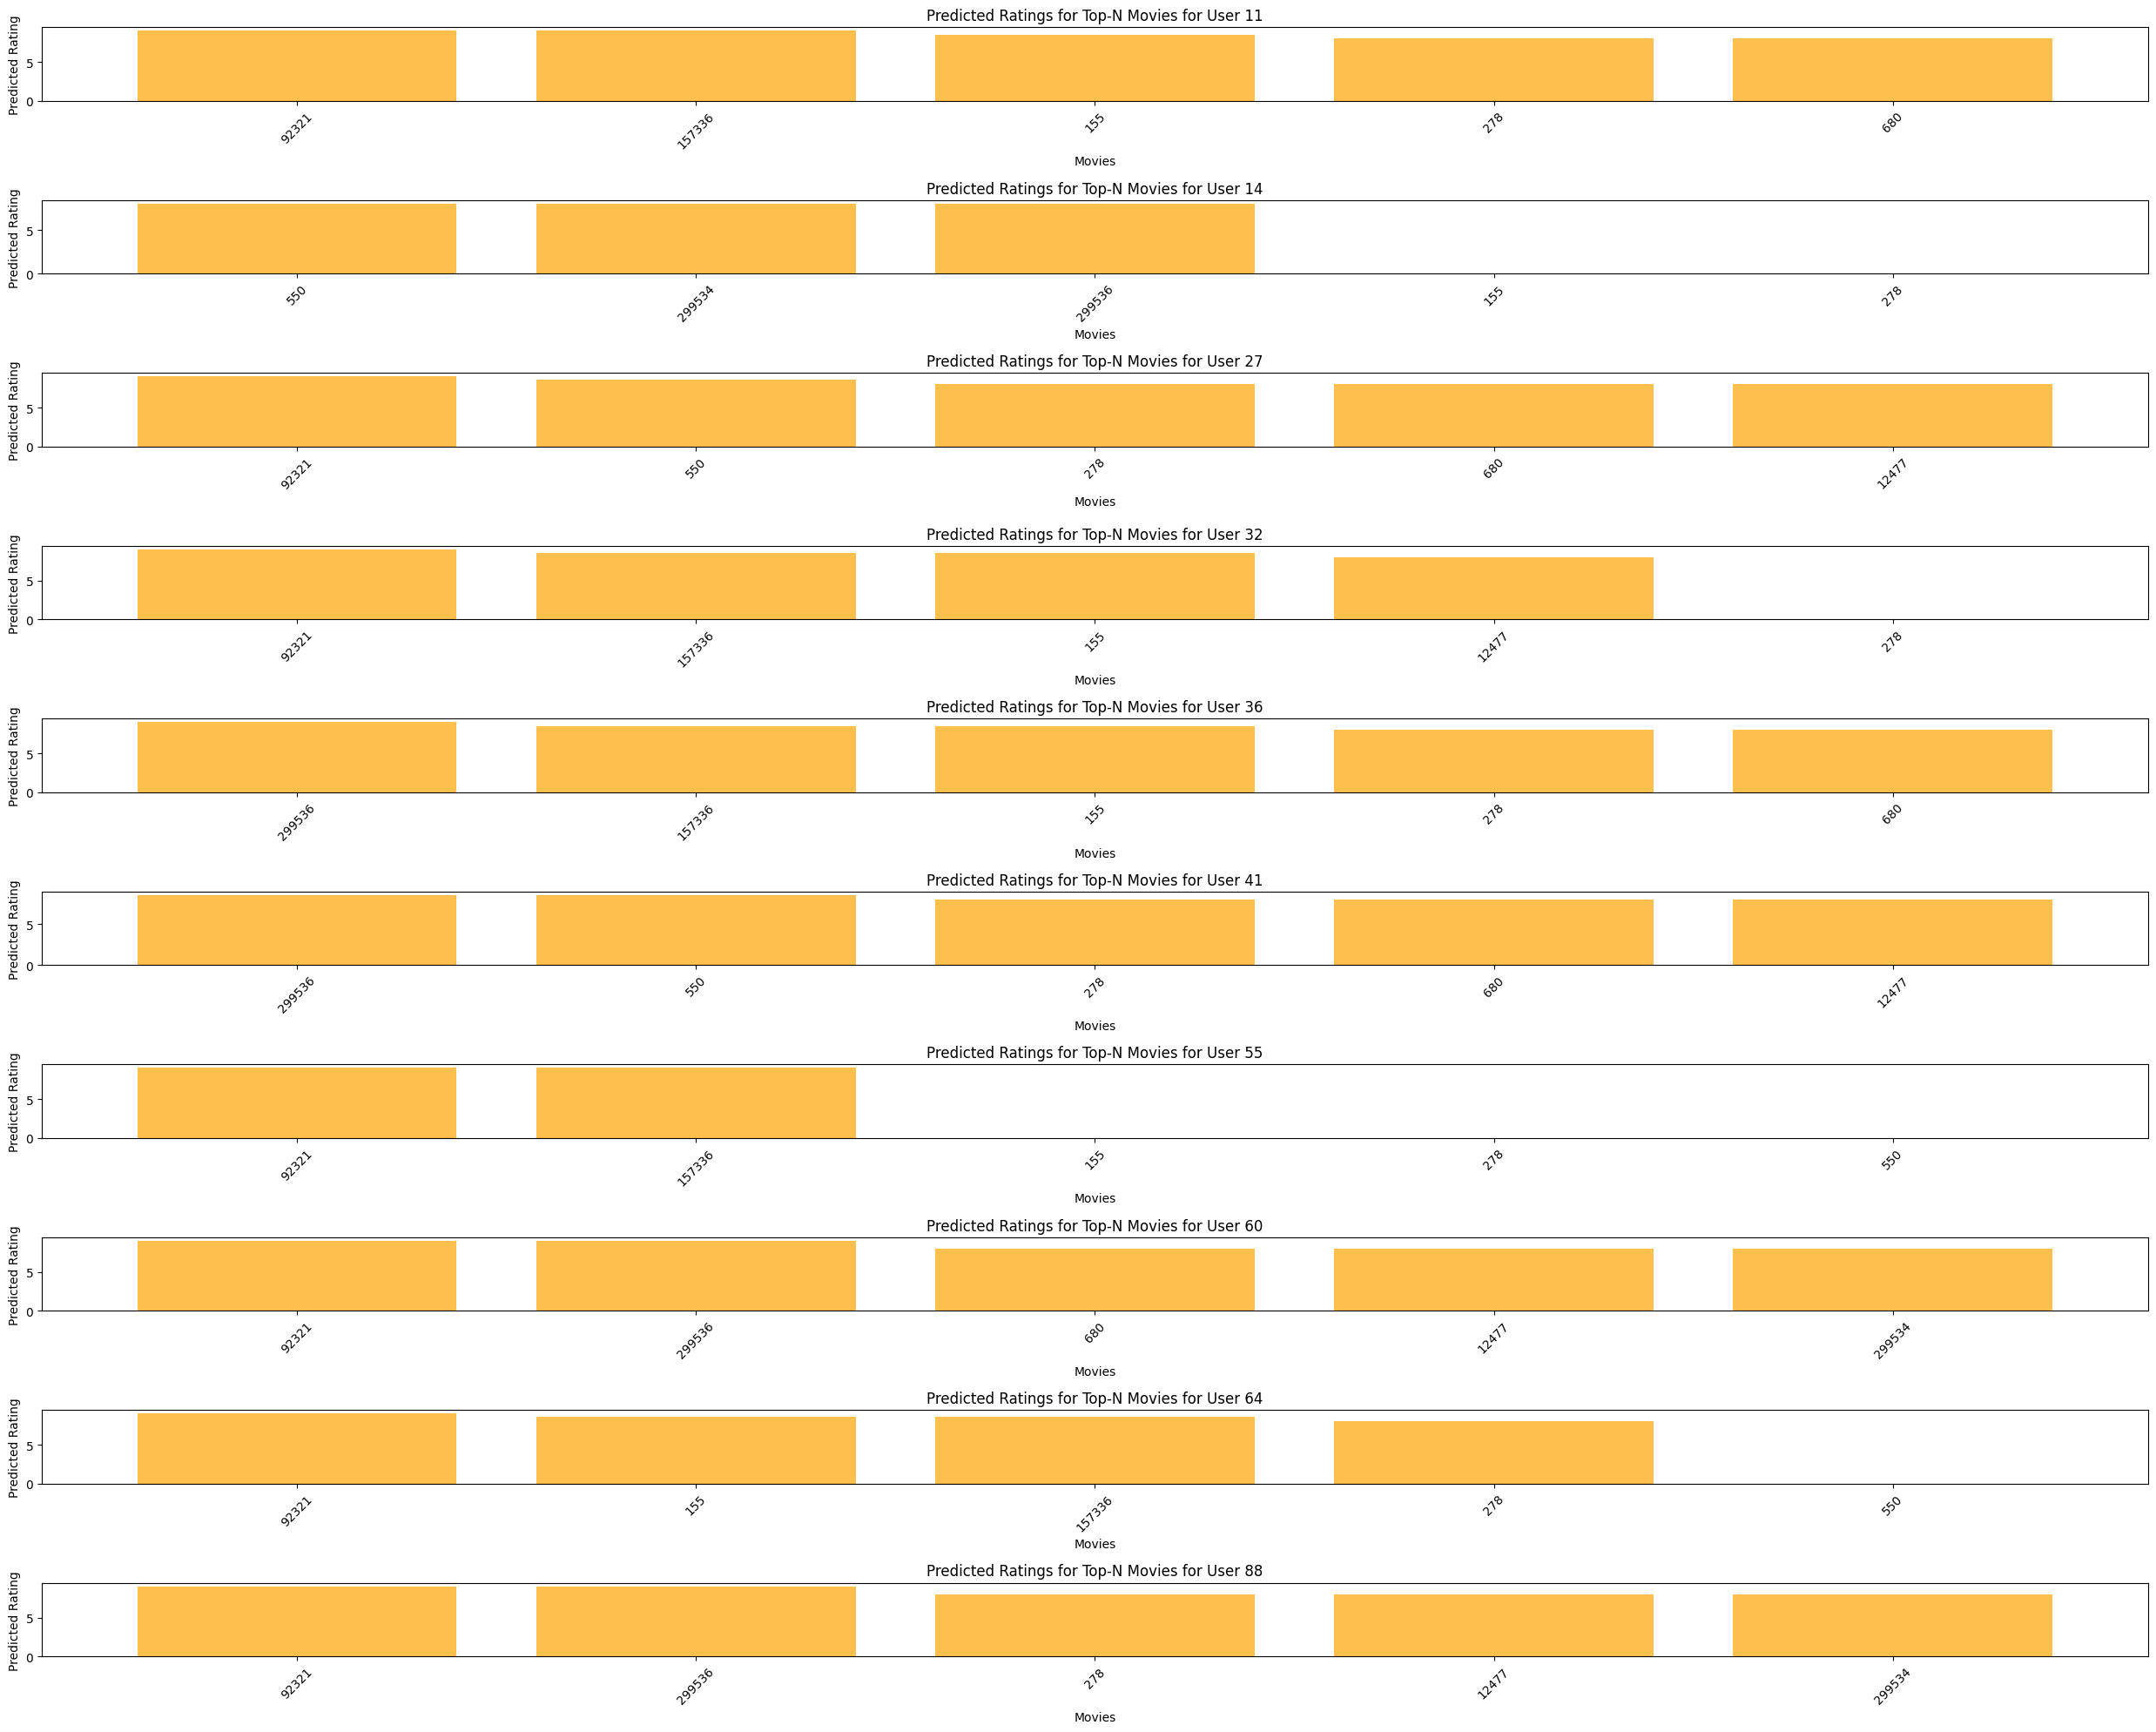

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data for predictions (Assuming you already have the predictions DataFrame)
# predictions = pd.DataFrame(...)  # Define this based on your actual data

# Ensure predictions DataFrames are numeric
predictions = predictions.apply(pd.to_numeric, errors='coerce').fillna(0)

# Function to get Top-N recommendations for a user with optional threshold and noise
def get_top_n_recommendations(predictions, n=5, threshold=None, noise_level=0):
    top_n = {}
    for user_id in predictions.index:
        user_ratings = predictions.loc[user_id]

        # Apply threshold if specified
        if threshold:
            user_ratings = user_ratings[user_ratings >= threshold]

        # Add random noise if specified
        if noise_level > 0:
            user_ratings = user_ratings + np.random.normal(0, noise_level, user_ratings.shape)

        # Get top N recommendations
        top_n[user_id] = user_ratings.nlargest(n).index.tolist()
    return top_n

# Generate Top-N recommendations for cosine similarity
top_n_cosine = get_top_n_recommendations(predictions, n=5)

# Function to extract predicted ratings for top-N recommendations
def extract_predictions_for_top_n(predictions, top_n):
    comparison_data = []
    
    for user in top_n.keys():
        for movie in top_n[user]:
            predicted_rating = predictions.loc[user, movie]
            comparison_data.append({
                'User ID': user,
                'top-N recommended movies': movie,
                'Predicted Rating': predicted_rating
            })
    
    return pd.DataFrame(comparison_data)

# Extract the predicted ratings for top-N recommendations
comparison_df = extract_predictions_for_top_n(predictions, top_n_cosine)

# Display the comparison DataFrame
print("\n================== Comparison of Predicted Ratings and Top-N Recommendations ==================")
print(comparison_df)

# Step 2: Plotting the Comparison
plt.figure(figsize=(25, 20))

# Group by User ID for plotting
for user in comparison_df['User ID'].unique():
    user_data = comparison_df[comparison_df['User ID'] == user]
    
    plt.subplot(len(comparison_df['User ID'].unique()), 1, list(comparison_df['User ID'].unique()).index(user) + 1)
    plt.bar(user_data['top-N recommended movies'], user_data['Predicted Rating'], color='orange', alpha=0.7)
    
    plt.title(f'Predicted Ratings for Top-N Movies for User {user}')
    plt.xlabel('Movies')
    plt.ylabel('Predicted Rating')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()